# ***LSTM for Emotion Analysis***

# **Imports and Dependencies**

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns

# **Data Forming and Cleaning & Statistics**

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

def load_data(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            text, label = line.strip().split(';')
            data.append(text)
            labels.append(label)
    df = pd.DataFrame({'text': data, 'label': labels})
    df['text'] = df['text'].apply(clean_text)
    return df
    

train_data = load_data('/kaggle/input/emotions-dataset-for-nlp/train.txt')
val_data = load_data('/kaggle/input/emotions-dataset-for-nlp/val.txt')
test_data = load_data('/kaggle/input/emotions-dataset-for-nlp/test.txt')

In [3]:
print("Train Data Information:\n")
train_data.info()
print("\nValidation Data Information:\n")
val_data.info()
print("\nTest Data Information:\n")
test_data.info()

Train Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

Validation Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

Test Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [4]:
print("Train Data Statistics:\n")
train_data.describe()

Train Data Statistics:



,text,label
count,16000,16000
unique,15969,6
top,im still not sure why reilly feels the need to...,joy
freq,2,5362


In [5]:
print("Validation Data Statistics:\n")
val_data.describe()

Validation Data Statistics:



,text,label
count,2000,2000
unique,1998,6
top,i feel so tortured by it,joy
freq,2,704


In [6]:
print("Test Data Statistics:\n")
test_data.describe()

Test Data Statistics:



,text,label
count,2000,2000
unique,2000,6
top,i feel all weird when i have to meet w people ...,joy
freq,1,695


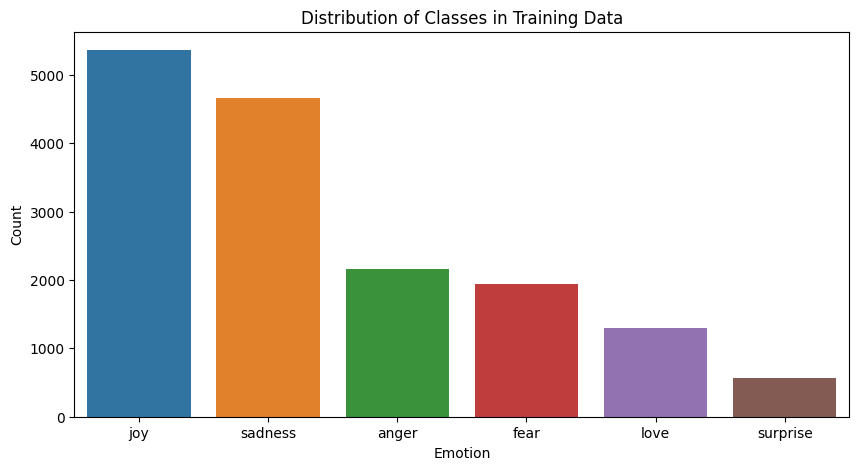

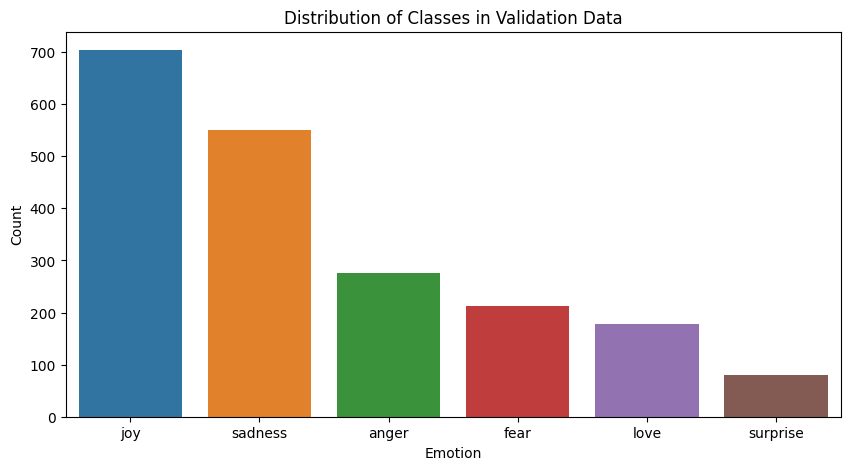

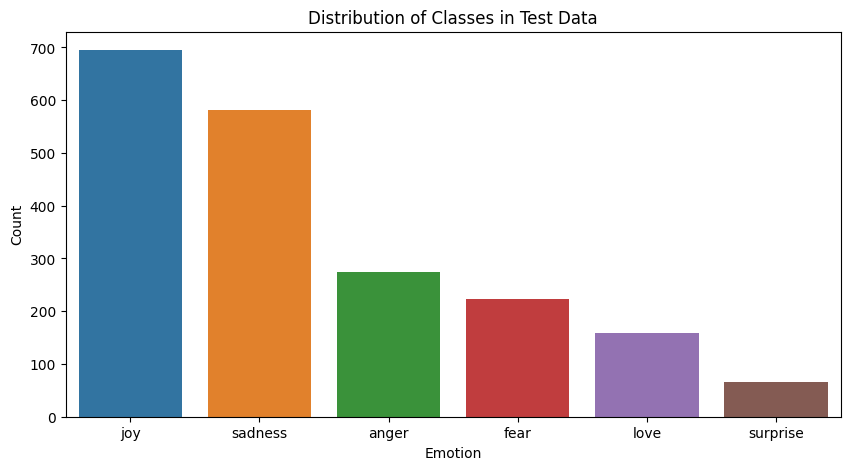

In [7]:
def visualize_data(df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
    plt.title(f'Distribution of Classes in {title}')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

visualize_data(train_data, 'Training Data')
visualize_data(val_data, 'Validation Data')
visualize_data(test_data, 'Test Data')

# **Tokenization and Padding**

**Explanation:** 
1. **Tokenizer Initialization:** Tokenizer is a class from Keras that helps in converting text into numerical sequences. 
    * num_words=20000 specifies that only the 20,000 most frequent words will be considered.
    * oov_token="<OOV>" is used to handle out-of-vocabulary words, replacing words not in the top 20,000 with this token.
2. **Fitting Tokenizer:** tokenizer.fit_on_texts(train_data['text']) builds the internal vocabulary based on the training text data.
    * Example: If the training text contains "I feel happy" and "I feel sad", the tokenizer might create a vocabulary where "I"=1, "feel"=2, "happy"=3, "sad"=4.
3. **Text Conversion:** texts_to_sequences converts each text to a sequence of integers based on the vocabulary built during tokenization.
    * Example: For the sentence "I feel happy": With vocabulary: {"I": 1, "feel": 2, "happy": 3} -> The sequence would be [1, 2, 3].
4. **Padding:** pad_sequences ensures that all sequences have the same length by padding shorter sequences with zeros (or truncating longer sequences).
    * maxlen=100 means that all sequences will be padded or truncated to a length of 100.
    * padding='post' means that padding will be added at the end of sequences.
    * Example:  1. Original sequences:
                    - [1, 2, 3] (length 3)
                    - [4, 5] (length 2)
                2. After padding to length 5:
                    - [1, 2, 3, 0, 0]
                    - [4, 5, 0, 0, 0]

In [8]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text'])

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# **Label Encoding and Class Weight Calculation**

**Explanation:** 
1. **LabelEncoder Initialization:** LabelEncoder is a class from sklearn.preprocessing used to convert categorical labels into numeric values.
2. **Fitting the Encoder:** label_encoder.fit(train_data['label']) learns the mapping from each unique label to a unique integer based on the labels in the training data.
    * Example: If train_data['label'] has labels like ['happy', 'sad', 'angry'], the encoder might map these to [0, 1, 2].
3. **Transforming Labels:** label_encoder.transform() converts the categorical labels into their corresponding numeric values.
    * Example: For labels ['happy', 'sad', 'happy'], the transformation might result in [0, 1, 0].
4. **Classes List:** classes = list(range(len(label_encoder.classes_))) generates a list of class indices.
    * Example: If there are 3 classes, classes would be [0, 1, 2].
5. **Class Weights Calculation:** compute_class_weight(class_weight='balanced', classes=classes, y=train_labels) computes weights for each class to address class imbalance.
    * class_weight='balanced' means weights are computed inversely proportional to class frequencies, giving more weight to less frequent classes.
    * Example: If class 0 appears 50 times and class 1 appears 200 times, class 0 will get a higher weight to counterbalance its lower frequency.
6. **Convert to Dictionary:** class_weights_dict = dict(enumerate(class_weights)) converts the array of class weights into a dictionary where the keys are class indices.
    * Example: Suppose you have three classes in your dataset and after computing class weights, you get the following array: class_weights = [1.5, 0.5, 2.0], This array indicates the weights for each class, where:
        - Class 0 has a weight of 1.5
        - Class 1 has a weight of 0.5
        - Class 2 has a weight of 2.0
    * To convert this array into a dictionary where the keys are class indices, you can use the enumerate function and dict() constructor: class_weights_dict = dict(enumerate(class_weights)).
    * enumerate(class_weights) pairs each weight with its index in the array. For class_weights = [1.5, 0.5, 2.0], enumerate produces:
        - (0, 1.5) for class 0
        - (1, 0.5) for class 1
        - (2, 2.0) for class 2

    * dict(enumerate(class_weights)) converts these pairs into a dictionary, so the result is class_weights_dict = {0: 1.5, 1: 0.5, 2: 2.0}.




In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(train_data['label'])
train_labels = label_encoder.transform(train_data['label'])
val_labels = label_encoder.transform(val_data['label'])
test_labels = label_encoder.transform(test_data['label'])

classes = list(range(len(label_encoder.classes_)))  # Ensures all classes are included
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Train Labels: ", train_labels)
print("Validation Labels: ", val_labels)
print("Test Labels: ", test_labels)

Train Labels:  [4 4 0 ... 2 0 4]
Validation Labels:  [4 4 3 ... 2 2 2]
Test Labels:  [4 4 4 ... 2 2 1]


# **Creating the Model**

In [10]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# **Training the Model**

In [13]:
history = model.fit(
    train_padded, train_labels,
    validation_data=(val_padded, val_labels),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr],
    verbose=2
)

Epoch 1/20
500/500 - 16s - 32ms/step - accuracy: 0.4906 - loss: 1.2377 - val_accuracy: 0.8460 - val_loss: 0.5004 - learning_rate: 0.0010
Epoch 2/20
500/500 - 9s - 18ms/step - accuracy: 0.8946 - loss: 0.3005 - val_accuracy: 0.9045 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 3/20
500/500 - 9s - 18ms/step - accuracy: 0.9328 - loss: 0.1830 - val_accuracy: 0.9060 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 4/20
500/500 - 9s - 18ms/step - accuracy: 0.9535 - loss: 0.1241 - val_accuracy: 0.9170 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 5/20
500/500 - 9s - 18ms/step - accuracy: 0.9653 - loss: 0.0948 - val_accuracy: 0.9190 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 6/20
500/500 - 9s - 18ms/step - accuracy: 0.9712 - loss: 0.0841 - val_accuracy: 0.9205 - val_loss: 0.2770 - learning_rate: 0.0010
Epoch 7/20
500/500 - 9s - 18ms/step - accuracy: 0.9751 - loss: 0.0758 - val_accuracy: 0.9135 - val_loss: 0.3062 - learning_rate: 0.0010
Epoch 8/20
500/500 - 9s - 18ms/step - accuracy:

# **Testing the Model**

In [14]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {test_accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8959 - loss: 0.5103
Test Accuracy: 0.9045


In [15]:
pred_labels = model.predict(test_padded).argmax(axis=-1)
print(classification_report(test_labels, pred_labels, target_names=label_encoder.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

       anger       0.89      0.91      0.90       275
        fear       0.87      0.84      0.86       224
         joy       0.94      0.91      0.93       695
        love       0.76      0.82      0.79       159
     sadness       0.96      0.95      0.95       581
    surprise       0.68      0.80      0.74        66

    accuracy                           0.90      2000
   macro avg       0.85      0.87      0.86      2000
weighted avg       0.91      0.90      0.91      2000



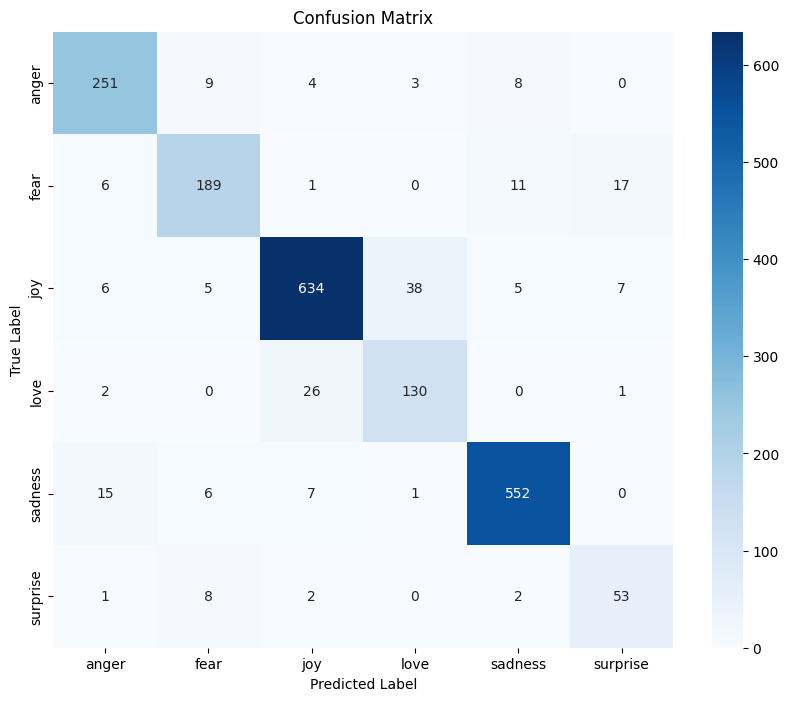

In [16]:
conf_matrix = confusion_matrix(test_labels, pred_labels)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Testing on Individual Samples**

In [17]:
# Function to predict the emotion of a given text
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded_sequence)
    emotion = label_encoder.inverse_transform([prediction.argmax()])
    return emotion[0]

In [18]:
# Example 1
text = "I'm feeling quite sad today."
print(f'Predicted emotion: {predict_emotion(text)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted emotion: sadness


In [25]:
# Example 2
text = "I have to be cautious and careful with Alfred, he is so unpredictable."
print(f'Predicted emotion: {predict_emotion(text)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted emotion: fear


In [20]:
# Example 3
text = "I am so annoyed and mad about the match, we did not deserve to lose."
print(f'Predicted emotion: {predict_emotion(text)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted emotion: anger


In [21]:
# Example 4
text = "Congratulations sweetie, I knew you were able to succeed!"
print(f'Predicted emotion: {predict_emotion(text)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted emotion: joy


In [22]:
# Example 5
text = "Wow, I am surprised that I actually won the lottery!"
print(f'Predicted emotion: {predict_emotion(text)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted emotion: surprise


In [23]:
model.save('emotion_model.h5')
loaded_model = load_model('emotion_model.h5')